In [26]:
import numpy as np
import scipy.sparse as sparse
import sympy as sp
import time
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.cm as cm1
import matplotlib.ticker as ticker

In [41]:
##------------------------Set numerical precision function-------------------##
###############################################################################
def set_numerical_precision():

    numerical_precision = input("Please enter the floating point precision you want to use (single/double): ")

    if numerical_precision == "single":

        float_precision = np.float32
        int_precision = np.int32

    else:

        float_precision = np.float64
        int_precision = np.int64

    return int_precision, float_precision;
###############################################################################

##-------------------------Get domain geometry function----------------------##
###############################################################################
def get_domain_geometry(float_precision):

    print("Please provide the dimensions of your rectangular domain in (m)\n")

    W = float_precision(input("Enter domain width in (m): ")) # Width (m)
    H = float_precision(input("Enter domain height in (m): ")) # Height (m)
    D = float_precision(input("Enter domain depth in (m): ")) # Depth (m)

    if min(H, W, D) >= 1e-3:

        print(f"Your domain measures H x W x D: {H:.4f} x {W:.4f} x {D:.4f} (m)\n")

    elif H < 1e-3:

        if W < 1e-3:

            if D < 1e-3:

                print(f"Your domain measures H x W x D: {H:.2e} x {W:.2e} x {D:.2e} (m)\n")

            else:

                print(f"Your domain measures H x W x D: {H:.2e} x {W:.2e} x {D:.4f} (m)\n")

        else:

            if D < 1e-3:

                print(f"Your domain measures H x W x D: {H:.2e} x {W:.4f} x {D:.2e} (m)\n")

            else:

                print(f"Your domain measures H x W x D: {H:.2e} x {W:.4f} x {D:.4f} (m)\n")

    elif W < 1e-3:

        if D > 1e-3:

            print(f"Your domain measures H x W x D: {H:.4f} x {W:.2e} x {D:.2e} (m)\n")

        else:

            print(f"Your domain measures H x W x D: {H:.4f} x {W:.2e} x {D:.4f} (m)\n")
    else:

        print(f"Your domain measures H x W x D: {H:.4f} x {W:.4f} x {D:.2e} (m)\n")

    plt.figure(0, figsize = (40, 40 * (H / W)))
    ax = plt.axes()

    filled_rect = patches.Rectangle(
        (0.0, 0.0),  # lower-left corner
        W,
        H,
        facecolor='lightgrey',       # fill color
        edgecolor='lightgrey',      # border color
        linewidth=0,
        zorder=0
    )

    ax.add_patch(filled_rect)

    plt.tick_params(axis='both', which='major', labelsize = 40)
    plt.xlabel('x', fontsize = 40, fontweight = "bold")
    plt.ylabel('y', fontsize = 40, fontweight = "bold")

    ax.margins(0.06)
    ax.set_aspect("equal", adjustable="box")

    return H, W, D;
###############################################################################

##----------------------Get material properties function---------------------##
###############################################################################
def get_material_properties(float_precision):

    print("Please provide the material properties\n")

    E = float_precision(input("Enter Young's Modulus in (Pa): ")) # Young modulus (Pa)
    v = float_precision(input("Enter Poisson ratio: ")) # Poisson ratio

    print("\nYour material has:\n")
    print(f"    Young's Modulus: {E / 1e9:.2f}e⁹ (Pa)")
    print(f"    Poisson ratio: {v:.2f}")

    return E, v;
###############################################################################

##-------------------------------Mesher class--------------------------------##
###############################################################################
class Mesh_2D:

    def __init__(self, H, W, dx, dy, elemType):

        self.H = H

        self.W = W

        self.dx = dx

        self.dy = dy

        self.elemType = elemType

        return;

    def StraightLineDiv(self, startp, endp, div):

        if startp[0]!=endp[0]:

            X = startp[0]*(1-div)+endp[0]*div
            Y = startp[1]

        else:

            X = startp[0]
            Y = startp[1]*(1-div)+endp[1]*div

        p=np.array([X, Y])

        return p;

    def Coons(self, int_precision, float_precision):

        self.elems_to_nodes = np.zeros((self.n_ksi * self.n_h, 4),dtype = int_precision)

        self.nodes_to_elems = [set() for _ in range(self.num_nodes)]

        self.nodal_coords_Base = np.zeros((self.num_nodes, 2), dtype = float_precision)

        for i in range(0, self.n_ksi):
            for j in range(0, self.n_h):

                n1 = (self.n_ksi + 1) * j + i + 1 - 1
                n2 = n1 + 1
                n3 = n2 + self.n_ksi + 1
                n4 = n3 - 1

                e = j * self.n_ksi + i

                self.elems_to_nodes[e, 0] = n1
                self.elems_to_nodes[e, 1] = n2
                self.elems_to_nodes[e, 2] = n3
                self.elems_to_nodes[e, 3] = n4

                self.nodes_to_elems[n1].add(e)
                self.nodes_to_elems[n2].add(e)
                self.nodes_to_elems[n3].add(e)
                self.nodes_to_elems[n4].add(e)

                self.nodal_coords_Base[n1,:] = [i / self.n_ksi, j / self.n_h]
                self.nodal_coords_Base[n2, :] = [(i + 1) / self.n_ksi, j / self.n_h]
                self.nodal_coords_Base[n3, :] = [(i + 1) / self.n_ksi, (j + 1) / self.n_h]
                self.nodal_coords_Base[n4, :] = [i / self.n_ksi, (j + 1) / self.n_h]

        return;

    def Linear_quad_shape_functions_calc(self, ):

        ksi, h = sp.symbols('ksi h')

        self.ksi = ksi
        self.h = h

        N1 =  (1 - ksi) * (1 - h) / 4
        N2 = (1 + ksi) * (1 - h) / 4
        N3 = (1 + ksi) * (1 + h) / 4
        N4 = (1 - ksi) * (1 + h) / 4

        N = sp.Matrix([[N1, N2, N3, N4, 0, 0, 0, 0],
                       [0, 0, 0, 0, N1, N2, N3, N4]])

        self.N_function = sp.lambdify((ksi, h), N, 'numpy')

        dN1_dksi = sp.diff(N1, ksi)
        dN1_dh = sp.diff(N1, h)

        dN2_dksi = sp.diff(N2, ksi)
        dN2_dh = sp.diff(N2, h)

        dN3_dksi = sp.diff(N3, ksi)
        dN3_dh = sp.diff(N3, h)

        dN4_dksi = sp.diff(N4, ksi)
        dN4_dh = sp.diff(N4, h)

        dN_dksi_dh = [[dN1_dksi, dN2_dksi, dN3_dksi, dN4_dksi],
                      [dN1_dh, dN2_dh, dN3_dh, dN4_dh]]

        self.dN_dksi_dh_function = sp.lambdify((ksi, h), dN_dksi_dh, 'numpy')

        return;

    def J_matrix_assembly(self, dN_dksi_dh, X):

        J = dN_dksi_dh @ X

        return J;

    def B_matrix_assembly(self, dN_dksi_dh, J):

        inv_J = np.linalg.inv(J)

        BB = inv_J @ dN_dksi_dh

        B = np.stack([np.concatenate([BB[0, :], np.zeros(4, )]),
                      np.concatenate([np.zeros(4, ), BB[1, :]]),
                      np.concatenate([BB[1, :], BB[0, :]])])

        return B;

    def node_element_generation(self, int_precision, float_precision):

        self.n_ksi = int_precision(self.W / self.dx)
        self.n_h = int_precision(self.H / self.dy)

        self.num_nodes = (self.n_ksi + 1) * (self.n_h + 1)

        A = np.array([0, 0], dtype = float_precision)
        B = np.array([self.W, 0], dtype = float_precision)
        C = np.array([self.W, self.H], dtype = float_precision)
        D = np.array([0, self.H], dtype = float_precision)

        self.Coons(int_precision, float_precision)

        self.nodal_coords = np.zeros((self.num_nodes, 2), dtype = float_precision)

        for i in range(0, self.n_ksi * self.n_h):
            for j in range(0, 4):

                ksi = self.nodal_coords_Base[self.elems_to_nodes[i, j], 0]
                h = self.nodal_coords_Base[self.elems_to_nodes[i, j], 1]

                E0_ksi = 1 - ksi
                E1_ksi = ksi
                E0_h = 1 - h
                E1_h = h

                AB = self.StraightLineDiv(A, B, ksi)
                BC = self.StraightLineDiv(B, C, h)
                CD = self.StraightLineDiv(D, C, ksi)
                DA = self.StraightLineDiv(A, D, h)

                self.nodal_coords[self.elems_to_nodes[i, j], 0] = E0_ksi * DA[0] + \
                                                         E1_ksi * BC[0] + \
                                                         E0_h * AB[0] + \
                                                         E1_h * CD[0] - \
                                                         E0_ksi * E0_h * A[0] - \
                                                         E1_ksi * E0_h * B[0] - \
                                                         E0_ksi * E1_h * D[0] - \
                                                         E1_ksi * E1_h * C[0]

                self.nodal_coords[self.elems_to_nodes[i, j], 1] = E0_ksi * DA[1] + \
                                                         E1_ksi * BC[1] + \
                                                         E0_h * AB[1] + \
                                                         E1_h * CD[1] - \
                                                         E0_ksi * E0_h * A[1] - \
                                                         E1_ksi * E0_h * B[1] - \
                                                         E0_ksi * E1_h * D[1] - \
                                                         E1_ksi * E1_h * C[1]

        self.dx = W / self.n_ksi
        self.dy = H / self.n_h

        self.Linear_quad_shape_functions_calc()

        return;
###############################################################################

##-------------------------Generate mesh function----------------------------##
###############################################################################
def generate_Mesh(H, W, E, v, int_precision, float_precision):

    print("Please provide the element size\n")

    elementSize = float_precision(input("Enter element size in (m): "))
    dx = elementSize
    dy = elementSize

    valid_elementShapes = ['Quad']
    valid_matModels = ['Plane strain', 'Plane stress']

    print("\nPlease provide the element type\n")
    print("Available element shapes: ", valid_elementShapes)
    elementShape = input("Enter element shape: ")

    print("\nAvailable material models: ", valid_matModels)
    matModel = input("Enter material model: ")

    elemType = {'shape': elementShape, 'matModel': matModel}

    time_start = time.time()

    Mesh = Mesh_2D(H, W, dx, dy, elemType)
    Mesh.node_element_generation(int_precision, float_precision)

    print("\nMeshing is complete | Time taken: %.2f s\n" %(time.time() - time_start))

    plt.figure(1, figsize = (40, 40 * (Mesh.H / Mesh.W)))
    ax = plt.axes()

    filled_rect = patches.Rectangle((0.0, 0.0),
                                    W,
                                    H,
                                    facecolor='cyan',
                                    edgecolor='cyan',
                                    linewidth=0,
                                    zorder=0)

    ax.add_patch(filled_rect)

    for elem in Mesh.elems_to_nodes:

        plt.plot(np.append(Mesh.nodal_coords[elem, 0], Mesh.nodal_coords[elem[0], 0]), np.append(Mesh.nodal_coords[elem, 1], Mesh.nodal_coords[elem[0], 1]), linewidth = 1, color = "black")

    plt.tick_params(axis='both', which='major', labelsize = 40)
    plt.xlabel('x', fontsize = 40, fontweight = "bold")
    plt.ylabel('y', fontsize = 40, fontweight = "bold")

    ax.margins(0.06)
    ax.set_aspect("equal", adjustable="box")

    return Mesh;
###############################################################################

##---------------------Gauss points selection function-----------------------##
###############################################################################
def Gauss_points_selection_2D(float_precision):

    valind_n_Gauss_points = [2, ]

    print("\nPlease provide the number of Gauss points used for integration\n")
    print("Available number of Gauss points: ", valind_n_Gauss_points)

    n_Gauss_points = int(input("Enter the number of Gauss points: "))

    if n_Gauss_points == 2:

        Gauss_points = {"vals": [1.0 / np.sqrt(3.0, dtype = float_precision), -1.0 / np.sqrt(3.0, dtype = float_precision)],
                        "weights": [1.0, 1.0]}

    return Gauss_points;
###############################################################################

##----------------------Stifness matrix assembly function--------------------##
###############################################################################
def Global_Stifness_matrix_assembly_2D(E, v, D, Mesh, Gauss_points, float_precision):

    time_start = time.time()

    if Mesh.elemType['matModel'] == 'Plane stress':

        C_e = (E / (1.0 - v ** 2)) * np.array([[1, v, 0],
                                               [v, 1, 0],
                                               [0, 0, (1 - v)/ 2.0]], dtype = np.float32)

    elif Mesh.elemType['matModel'] == 'Plane strain':

        C_e = (E * (1.0 - v) / ((1.0 + v) * (1.0 - 2.0 * v))) * np.array([[1, v / (1.0 - v), 0],
                                                                          [v / (1.0 - v), 1, 0],
                                                                          [0, 0, (1.0 - 2.0 * v) / (2.0 * (1 - v))]], dtype = np.float32)

    Gauss_points_vals = Gauss_points["vals"]
    Gauss_points_weights = Gauss_points["weights"]

    rows = []
    cols = []
    vals = []

    for elem in Mesh.elems_to_nodes:

        index = np.concatenate([elem, elem + Mesh.num_nodes])

        X = Mesh.nodal_coords[elem]

        Local = np.zeros((8, 8))

        for i in range(len(Gauss_points_vals)):
            for j in range(len(Gauss_points_vals)):

                dN_dksi_dh = Mesh.dN_dksi_dh_function(Gauss_points_vals[i], Gauss_points_vals[j])

                J = Mesh.J_matrix_assembly(dN_dksi_dh, X)

                det_J = np.linalg.det(J)

                B = Mesh.B_matrix_assembly(dN_dksi_dh, J)

                Local += Gauss_points_weights[i] * Gauss_points_weights[j] * D * (B.T @ C_e @ B) * det_J

        rows.extend(np.repeat(index, index.shape[0]))
        cols.extend(np.tile(index, index.shape[0]))
        vals.extend(Local.ravel())

    K = sparse.coo_matrix((vals, (rows, cols)), shape=(2 * Mesh.num_nodes, 2 * Mesh.num_nodes), dtype = float_precision).tocsr()

    print("Global Stifness matrix is assembled | Time taken: %.2f s\n" %(time.time() - time_start))

    return C_e, K;
###############################################################################

##----------------------Vertices/Edge constraints function-------------------##
###############################################################################
def Vertices_Edge_constraints(Mesh, int_precision, float_precision):

    fixed_DOFs = []

    free_DOFs = np.arange(2 * Mesh.num_nodes, dtype = int_precision)

    vertice_constraint_ON = input("\nState if you want to constraint a vertice (Y/N): ")

    if vertice_constraint_ON == "Y":

        n_vertice_constraints = int_precision(input("\nEnter how many vertices are constrained: "))

        for i in range(n_vertice_constraints):

            vertice_coords = [float_precision(j) for j in input(f"\nEnter x, y (separated by spaces or commas) for vertice {i + 1:d}: ").replace(",", " ").split()]

            DOFs_constrained = input("State which DOFs are constrained (x, y, both): ")

            mask_vertice = (Mesh.nodal_coords[:, 0] >= vertice_coords[0] - Mesh.dx / 4.0) & (Mesh.nodal_coords[:, 0] <= vertice_coords[0] + Mesh.dx / 4.0) & (Mesh.nodal_coords[:, 1] >= vertice_coords[1] - Mesh.dy / 4.0) & (Mesh.nodal_coords[:, 1] <= vertice_coords[1] + Mesh.dy / 4.0)

            vertice_constraint_node_indices = np.where(mask_vertice == True)[0]

            if DOFs_constrained == 'x':

                fixed_DOFs.extend(vertice_constraint_node_indices)

            elif DOFs_constrained == 'y':

                fixed_DOFs.extend(vertice_constraint_node_indices + Mesh.num_nodes)

            elif DOFs_constrained == 'both':

                fixed_DOFs.extend(np.append(vertice_constraint_node_indices, vertice_constraint_node_indices + Mesh.num_nodes))

    edge_constraint_ON = input("\nState if you want to constrain an edge (Y/N): ")

    if edge_constraint_ON == "Y":

        n_edge_constraints = int_precision(input("\nEnter how many edges are constrained: "))

        for i in range(n_edge_constraints):

            edge_coords = [float_precision(j) for j in input(f"\nEnter xMin, yMin, xMax, yMax (separated by spaces or commas) for edge {i + 1:d}: ").replace(",", " ").split()]

            DOFs_constrained = input("State which DOFs are constrained (x, y, both): ")

            mask_edge = (Mesh.nodal_coords[:, 0] >= edge_coords[0] - Mesh.dx / 4.0) & (Mesh.nodal_coords[:, 0] <= edge_coords[2] + Mesh.dx / 4.0) & (Mesh.nodal_coords[:, 1] >= edge_coords[1] - Mesh.dy / 4.0) & (Mesh.nodal_coords[:, 1] <= edge_coords[3] + Mesh.dy / 4.0)

            edge_constraint_node_indices = np.where(mask_edge == True)[0]

            if DOFs_constrained == 'x':

                fixed_DOFs.extend(edge_constraint_node_indices)

            elif DOFs_constrained == 'y':

                fixed_DOFs.extend(edge_constraint_node_indices + Mesh.num_nodes)

            elif DOFs_constrained == 'both':

                fixed_DOFs.extend(np.append(edge_constraint_node_indices, edge_constraint_node_indices + Mesh.num_nodes))

    fixed_DOFs = int_precision(np.unique(fixed_DOFs))

    free_DOFs = np.delete(free_DOFs, fixed_DOFs)

    return fixed_DOFs, free_DOFs;

def Vertices_loads(Mesh, loaded_DOFs, F, int_precision, float_precision):

    n_vertice_load = int_precision(input("\nEnter how many vertices are loaded: "))

    for i in range(n_vertice_load):

        vertice_coords = [float_precision(j) for j in input(f"\nEnter x, y (separated by spaces or commas) for vertice {i + 1:d}: ").replace(",", " ").split()]

        mask_vertice = (Mesh.nodal_coords[:, 0] >= vertice_coords[0] - Mesh.dx / 4.0) & (Mesh.nodal_coords[:, 0] <= vertice_coords[0] + Mesh.dx / 4.0) & (Mesh.nodal_coords[:, 1] >= vertice_coords[1] - Mesh.dy / 4.0) & (Mesh.nodal_coords[:, 1] <= vertice_coords[1] + Mesh.dy / 4.0)

        vertice_load_node_indices = np.where(mask_vertice == True)[0]

        F[vertice_load_node_indices] = float_precision(input("Enter signed amplitude of x-component in (N): "))
        F[vertice_load_node_indices + Mesh.num_nodes] = float_precision(input("Enter signed amplitude of y-component in (N): "))

        if F[vertice_load_node_indices] != 0:

            loaded_DOFs.extend(vertice_load_node_indices)

        if F[vertice_load_node_indices + Mesh.num_nodes] != 0:

            loaded_DOFs.extend(vertice_load_node_indices + Mesh.num_nodes)

    return loaded_DOFs, F;

def Edges_loads(Mesh, loaded_DOFs, F, Gauss_points, int_precision, float_precision):

    Gauss_points_vals = Gauss_points["vals"]
    Gauss_points_weights = Gauss_points["weights"]

    edge_meta = {(0,1): {"const": "h", "const_val": -1.0, "J_row": 0},
                 (1,0): {"const": "h", "const_val": -1.0, "J_row": 0},

                (1,2): {"const": "ksi",  "const_val": +1.0, "J_row": 1},
                (2,1): {"const": "ksi",  "const_val": +1.0, "J_row": 1},

                (2,3): {"const": "h", "const_val": +1.0, "J_row": 0},
                (3,2): {"const": "h", "const_val": +1.0, "J_row": 0},

                (3,0): {"const": "ksi",  "const_val": -1.0, "J_row": 1},
                (0,3): {"const": "ksi",  "const_val": -1.0, "J_row": 1}}

    n_edge_load = int_precision(input("\nEnter how many edges are loaded: "))

    for i in range(n_edge_load):

        edge_coords = [float_precision(j) for j in input(f"\nEnter xMin, yMin, xMax, yMax (separated by spaces or commas) for edge {i + 1:d}: ").replace(",", " ").split()]

        mask_edge = (Mesh.nodal_coords[:, 0] >= edge_coords[0] - Mesh.dx / 4.0) & (Mesh.nodal_coords[:, 0] <= edge_coords[2] + Mesh.dx / 4.0) & (Mesh.nodal_coords[:, 1] >= edge_coords[1] - Mesh.dy / 4.0) & (Mesh.nodal_coords[:, 1] <= edge_coords[3] + Mesh.dy / 4.0)

        edge_load_node_indices = np.where(mask_edge == True)[0]

        qx =  float_precision(input("Enter signed amplitude of x-component in (N/m): "))
        qy =  float_precision(input("Enter signed amplitude of y-component in (N/m): "))

        for i in range(edge_load_node_indices.shape[0] - 1):

            e = list(Mesh.nodes_to_elems[edge_load_node_indices[i]] & Mesh.nodes_to_elems[edge_load_node_indices[i + 1]])[0]

            elem = Mesh.elems_to_nodes[e]

            n1 = int(np.where(elem == edge_load_node_indices[i])[0][0])
            n2 = int(np.where(elem == edge_load_node_indices[i + 1])[0][0])

            X = Mesh.nodal_coords[elem]

            for Gauss_points_val, Gauss_points_weight in zip(Gauss_points_vals, Gauss_points_weights):

                if edge_meta[(n1, n2)]["const"] == "ksi":

                    ksi = edge_meta[(n1, n2)]["const_val"]
                    h = Gauss_points_val

                elif edge_meta[(n1, n2)]["const"] == "h":

                    ksi = Gauss_points_val
                    h = edge_meta[(n1, n2)]["const_val"]

                J_row = edge_meta[(n1, n2)]["J_row"]

                N = Mesh.N_function(ksi, h)

                dN_dksi_dh = Mesh.dN_dksi_dh_function(ksi, h)

                J = Mesh.J_matrix_assembly(dN_dksi_dh, X)

                F[np.append(elem, elem + Mesh.num_nodes)] += Gauss_points_weight * (N.T @ np.append(qx, qy)) * np.sqrt(np.sum(J[J_row] ** 2))

    if qx != 0:

        loaded_DOFs.extend(edge_load_node_indices)

    if qy != 0:

        loaded_DOFs.extend(edge_load_node_indices + Mesh.num_nodes)

    return loaded_DOFs, F;

def loads(Mesh, Gauss_points, int_precision, float_precision):

    loaded_DOFs = []

    F = np.zeros(2 * Mesh.num_nodes, dtype = float_precision)

    vertice_load_ON = input("\nPlease state if you want to load a vertice (Y/N): ")

    if vertice_load_ON == "Y":

        loaded_DOFs, F = Vertices_loads(Mesh, loaded_DOFs, F, Gauss_points, int_precision, float_precision)

    edge_load_ON = input("\nPlease if you want to load an edge (Y/N): ")

    if edge_load_ON == "Y":

        loaded_DOFs, F = Edges_loads(Mesh, loaded_DOFs, F, Gauss_points, int_precision, float_precision)

    return loaded_DOFs, F

def BC_loads(Mesh, Gauss_points, int_precision, float_precision):

    BC_ON = input("Please state if kinematic constraints will be imposed on the model (Y/N): ")

    if BC_ON == "Y":

        fixed_DOFs, free_DOFs = Vertices_Edge_constraints(Mesh, int_precision, float_precision)

    else:

       fixed_DOFs = np.array([], dtype = int_precision)

       free_DOFs = np.arange(2 * Mesh.num_nodes, dtype = int_precision)

    loaded_DOFs, F = loads(Mesh, Gauss_points, int_precision, float_precision)

    plt.figure(2, figsize = (40, 40 * (Mesh.H / Mesh.W)))
    ax = plt.axes()

    filled_rect = patches.Rectangle(
        (0.0, 0.0),  # lower-left corner
        Mesh.W,
        Mesh.H,
        facecolor='lightgrey',       # fill color
        edgecolor='lightgrey',      # border color
        linewidth=0,
        zorder=0
    )

    ax.add_patch(filled_rect)

    tri_side_size = 4 * Mesh.dx

    arrow_length = 12 * Mesh.dx

    for i in fixed_DOFs:

        if i < Mesh.num_nodes:

            tri = patches.Polygon([(Mesh.nodal_coords[i, 0], Mesh.nodal_coords[i, 1]),
                                   (Mesh.nodal_coords[i, 0] - np.sqrt(3) * tri_side_size / 2.0, Mesh.nodal_coords[i, 1] + tri_side_size / 2),
                                   (Mesh.nodal_coords[i, 0] - np.sqrt(3) * tri_side_size / 2.0, Mesh.nodal_coords[i, 1] - tri_side_size / 2)],
                                  closed=True, facecolor="orange", edgecolor='orange')

            ax.add_patch(tri)

        else:

            tri = patches.Polygon([(Mesh.nodal_coords[i - Mesh.num_nodes, 0], Mesh.nodal_coords[i - Mesh.num_nodes, 1]),
                                   (Mesh.nodal_coords[i - Mesh.num_nodes, 0] - tri_side_size / 2.0, Mesh.nodal_coords[i - Mesh.num_nodes, 1] - np.sqrt(3) * tri_side_size / 2),
                                   (Mesh.nodal_coords[i - Mesh.num_nodes, 0] + tri_side_size / 2.0, Mesh.nodal_coords[i - Mesh.num_nodes, 1] - np.sqrt(3) * tri_side_size / 2)],
                                  closed=True, facecolor="orange", edgecolor='orange')

            ax.add_patch(tri)

    for i in loaded_DOFs:

        if i < Mesh.num_nodes:

            arrow = patches.FancyArrowPatch((Mesh.nodal_coords[i, 0], Mesh.nodal_coords[i, 1]),
                                            (Mesh.nodal_coords[i, 0] + np.sign(F[i]) * arrow_length, Mesh.nodal_coords[i, 1]),
                                            arrowstyle='-|>',
                                            mutation_scale=25,
                                            linewidth=3,
                                            color='red',
                                            zorder=1)

            ax.add_patch(arrow)

        else:

            arrow = patches.FancyArrowPatch((Mesh.nodal_coords[i - Mesh.num_nodes, 0], Mesh.nodal_coords[i - Mesh.num_nodes, 1]),
                                            (Mesh.nodal_coords[i - Mesh.num_nodes, 0], Mesh.nodal_coords[i - Mesh.num_nodes, 1] + np.sign(F[i]) * arrow_length),
                                            arrowstyle='-|>',
                                            mutation_scale=25,
                                            linewidth=3,
                                            color='red',
                                            zorder=1)

            ax.add_patch(arrow)

    plt.tick_params(axis='both', which='major', labelsize = 40)
    plt.xlabel('x', fontsize = 40, fontweight = "bold")
    plt.ylabel('y', fontsize = 40, fontweight = "bold")

    ax.margins(0.06)
    ax.set_aspect("equal", adjustable="box")

    return fixed_DOFs, free_DOFs, loaded_DOFs, F;
###############################################################################

##------------------------------Solver function------------------------------##
###############################################################################
def solve(K, free_DOFs, F, float_precision):

    print("Solution started\n")

    time_start = time.time()

    U = np.zeros(2 * Mesh.num_nodes, float_precision)

    K_effective = K[np.ix_(free_DOFs, free_DOFs)].copy()
    K_effective_LU = sparse.linalg.splu(K_effective)

    F_effective = F[free_DOFs].copy()

    U[free_DOFs] = K_effective_LU.solve(F_effective)

    print("\nSolution is completed | Time taken: %.2f s\n" %(time.time() - time_start))

    return U;
###############################################################################

###############################################################################
class Post_processing2D:

    def __init__(self, ):

        self.labelsize = 40

        self.fontsize = 40

        self.my_cmap = cm1.jet

        self.Var_list = ['Ux', 'Uy', 'U_abs', 'Sxx', 'Syy', 'Sxy', 'S_VonMises']
        self.Var_units_list = ['(m)', '(m)', '(m)', '(Pa)', '(Pa)', '(Pa)', '(Pa)']

        return;

    def plotVar(self, Mesh, C_e, U, Gauss_points, float_precision):

        Gauss_points_vals = Gauss_points["vals"]

        print("Available variables to plot: ", self.Var_list)
        Var = input("Enter the variable you want to plot: ")

        show_mesh = input("\nState if you want to plot the mesh (Y/N): ")

        deformed = input("\nState if you want to plot the deformed configuration (Y/N): ")

        if show_mesh == "Y":

            show_mesh = True

        if deformed == "Y":

            deformed = True

            exaggerationFactor = 0
            exaggeration_ON = input("State if you want to plot an exaggerate deformed configuration (Y/N): ")

            if exaggeration_ON == "Y":

                exaggerationFactor = float_precision(input("Enter the desired exaggeration factor (can be integer of float): "))

        else:

            deformed = False

        Var_index = [i for i, x in enumerate(self.Var_list) if x == Var][0]

        colorbar_label = self.Var_list[Var_index] + ' ' + self.Var_units_list[Var_index]

        if Var[0] == 'U':

            if Var == 'Ux':

                Var_plot = U[:Mesh.num_nodes].copy()

            elif Var == 'Uy':

                Var_plot = U[Mesh.num_nodes:].copy()

            elif Var == 'U_abs':

                Var_plot = np.sqrt(U[:Mesh.num_nodes] ** 2 + U[Mesh.num_nodes:] ** 2)

        elif Var[0] == 'S':

            if Mesh.elemType['shape'] == 'Quad':

                N_Gauss_points = np.zeros((len(Gauss_points_vals) ** 2, len(Gauss_points_vals) ** 2), float_precision)

                sxx = np.zeros(Mesh.num_nodes, float_precision)

                syy = np.zeros(Mesh.num_nodes, float_precision)

                sxy = np.zeros(Mesh.num_nodes, float_precision)

                for elem in Mesh.elems_to_nodes:

                    sxx_Gauss_points = np.zeros(len(Gauss_points_vals) ** 2, )

                    syy_Gauss_points = np.zeros(len(Gauss_points_vals) ** 2, )

                    sxy_Gauss_points = np.zeros(len(Gauss_points_vals) ** 2, )

                    X = Mesh.nodal_coords[elem]

                    for i in range(len(Gauss_points_vals)):
                        for j in range(len(Gauss_points_vals)):

                            N_Gauss_points[len(Gauss_points_vals) * i + j] = Mesh.N_function(Gauss_points_vals[i], Gauss_points_vals[j])[0, :4]

                            dN_dksi_dh = Mesh.dN_dksi_dh_function(Gauss_points_vals[i], Gauss_points_vals[j])

                            J = Mesh.J_matrix_assembly(dN_dksi_dh, X)

                            B = Mesh.B_matrix_assembly(dN_dksi_dh, J)

                            sxx_Gauss_points[len(Gauss_points_vals) * i + j], syy_Gauss_points[len(Gauss_points_vals) * i + j], sxy_Gauss_points[len(Gauss_points_vals) * i + j] = (C_e @ B @ np.concatenate([U[elem], U[elem + Mesh.num_nodes]]).reshape(-1, 1)).reshape(-1)

                    inv_N_Gauss_points = np.linalg.inv(N_Gauss_points)

                    sxx[elem] += (inv_N_Gauss_points @ sxx_Gauss_points.reshape(-1, 1)).reshape(-1)

                    syy[elem] += (inv_N_Gauss_points @ syy_Gauss_points.reshape(-1, 1)).reshape(-1)

                    sxy[elem] += (inv_N_Gauss_points @ sxy_Gauss_points.reshape(-1, 1)).reshape(-1)

            if Var == 'Sxx':

                Var_plot = sxx.copy()

            elif Var == 'Syy':

                Var_plot = syy.copy()

            elif Var == 'Sxy':

                Var_plot = sxy.copy()

            elif Var == 'S_VonMises':

                Var_plot = np.sqrt(sxx ** 2 + syy ** 2 - sxx * syy + 3 * (sxy ** 2))

            Var_plot = Var_plot / np.unique(Mesh.elems_to_nodes, return_counts=True)[1]

        if deformed == False:

            nodal_coords_new = Mesh.nodal_coords.copy()

        else:

            nodal_coords_new = np.concatenate([(Mesh.nodal_coords[:, 0] + U[:Mesh.num_nodes] * exaggerationFactor).reshape(-1, 1), (Mesh.nodal_coords[:, 1] + U[Mesh.num_nodes:] * exaggerationFactor).reshape(-1, 1)], axis = 1)

        fig = plt.figure(Var_index + 3, figsize = (40, 40 * (Mesh.H / Mesh.W)))
        ax = plt.axes()

        if show_mesh == True:

            for elem in Mesh.elems_to_nodes:

                plt.plot(np.append(nodal_coords_new[elem, 0], nodal_coords_new[elem[0], 0]), np.append(nodal_coords_new[elem, 1], nodal_coords_new[elem[0], 1]), linewidth = 1, color = "black")

        im = plt.scatter(nodal_coords_new[:, 0], nodal_coords_new[:, 1], s = 100, c = Var_plot, cmap = self.my_cmap)

        cbar = fig.colorbar(im, ax=ax)
        cbar.formatter = ticker.FormatStrFormatter('%.2e')
        cbar.ax.tick_params(labelsize = self.labelsize)
        cbar.ax.set_title(colorbar_label, fontsize = self.fontsize, fontweight='bold', rotation=0, pad = 60)

        plt.tick_params(axis='both', which='major', labelsize = self.labelsize)
        plt.xlabel('x', fontsize = self.fontsize, fontweight = 'bold')
        plt.ylabel('y', fontsize = self.fontsize, fontweight = 'bold')

        ax.margins(0.0)
        ax.set_aspect("equal", adjustable="box")

        return;
###############################################################################

In [28]:
##---------------------Floating point precision setting----------------------##
###############################################################################
int_precision, float_precision = set_numerical_precision()
###############################################################################

Please enter the floating point precision you want to use (single/double): single


Please provide the dimensions of your rectangular domain in (m)

Enter domain width in (m): 0.5
Enter domain height in (m): 0.1
Enter domain depth in (m): 1.0
Your domain measures H x W x D: 0.1000 x 0.5000 x 1.0000 (m)



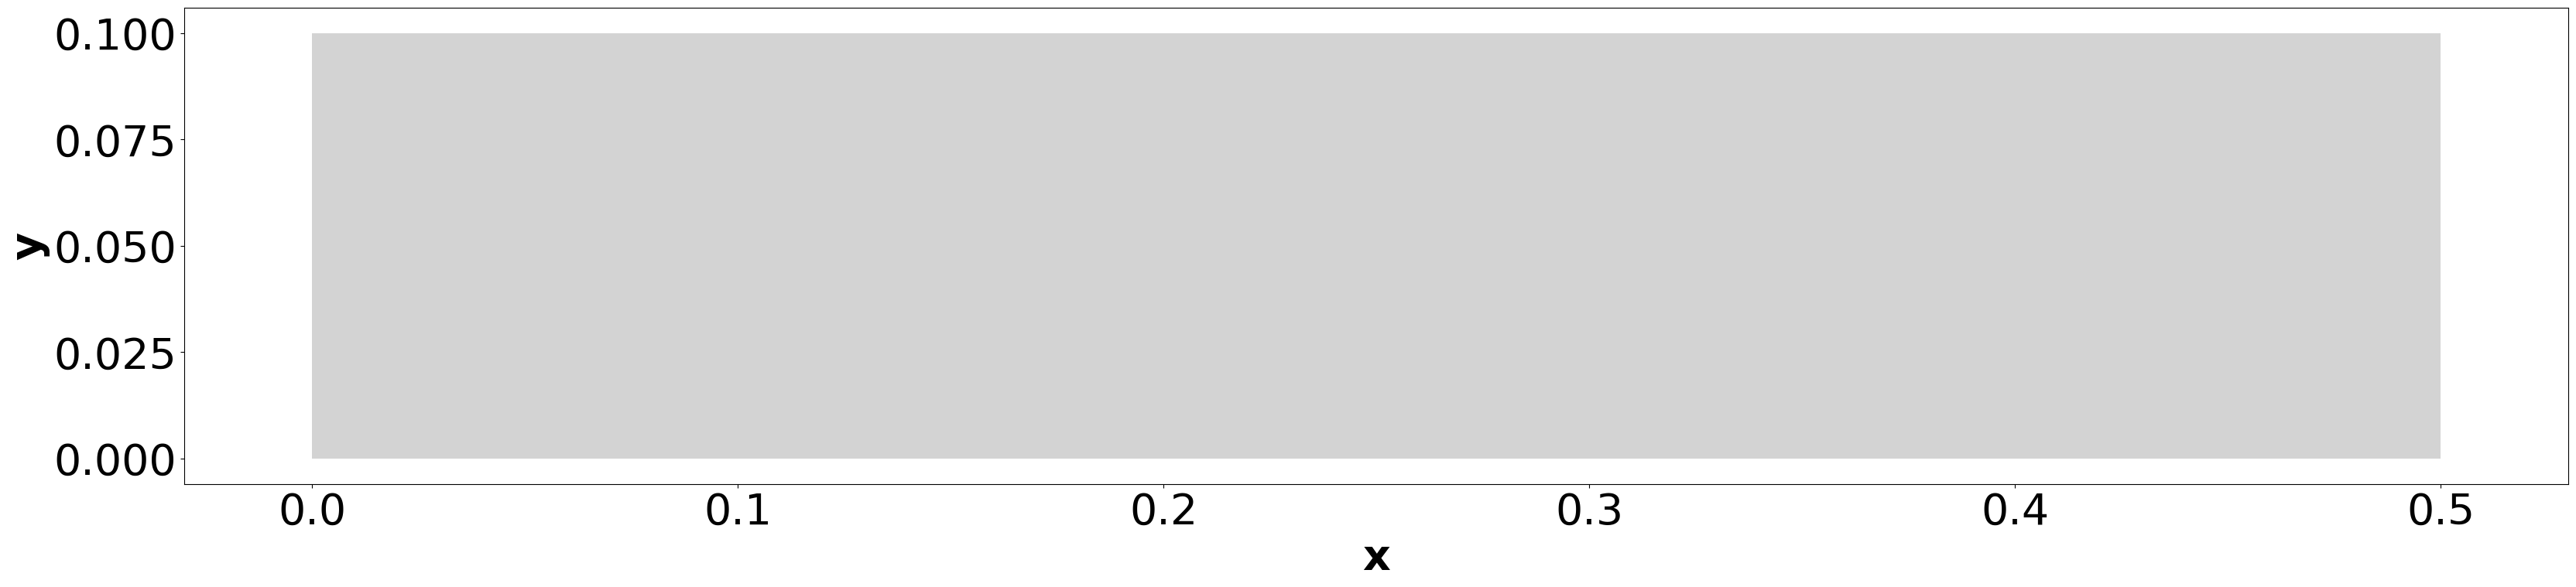

In [29]:
##-----------------------------Sample dimensions-----------------------------##
###############################################################################
H, W, D = get_domain_geometry(float_precision)
###############################################################################

In [30]:
##----------------------------Material properties----------------------------##
###############################################################################
E, v = get_material_properties(float_precision)
###############################################################################

Please provide the material properties

Enter Young's Modulus in (Pa): 69e9
Enter Poisson ratio: 0.33

Your material has:

    Young's Modulus: 69.00e⁹ (Pa)
    Poisson ratio: 0.33


Please provide the element size

Enter element size in (m): 1e-3

Please provide the element type

Available element shapes:  ['Quad']
Enter element shape: Quad

Available material models:  ['Plane strain', 'Plane stress']
Enter material model: Plane stress

Meshing is complete | Time taken: 2.81 s



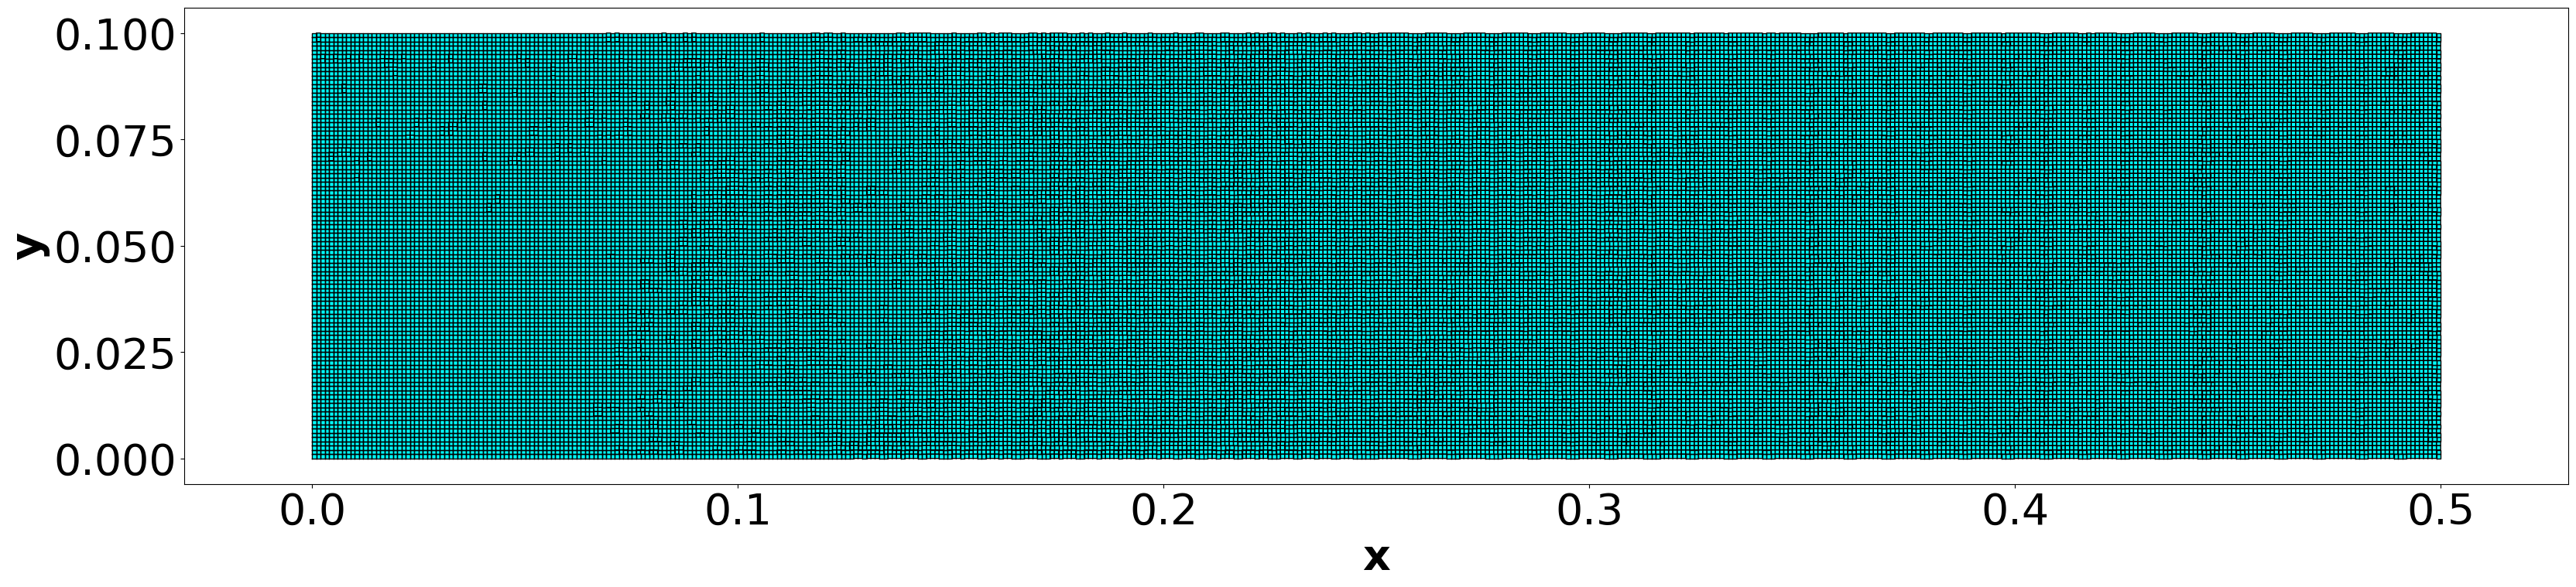

In [33]:
##---------------------------------Meshing-----------------------------------##
###############################################################################
Mesh = generate_Mesh(H, W, E, v, int_precision, float_precision)
###############################################################################

In [34]:
##--------------------------Gauss points selection---------------------------##
###############################################################################
Gauss_points = Gauss_points_selection_2D(float_precision)
###############################################################################


Please provide the number of Gauss points used for integration

Available number of Gauss points:  [2]
Enter the number of Gauss points: 2


In [35]:
##---------------------------Stifness matrix assembly------------------------##
###############################################################################
C_e, K = Global_Stifness_matrix_assembly_2D(E, v, D, Mesh, Gauss_points, float_precision)
###############################################################################

Global Stifness matrix is assembled | Time taken: 21.94 s



Please state if kinematic constraints will be imposed on the model (Y/N): Y

State if you want to constraint a vertice (Y/N): N

State if you want to constrain an edge (Y/N): Y

Enter how many edges are constrained: 2

Enter xMin, yMin, xMax, yMax (separated by spaces or commas) for edge 1: 0,0,0,0.1
State which DOFs are constrained (x, y, both): both

Enter xMin, yMin, xMax, yMax (separated by spaces or commas) for edge 2: 0.5,0,0.5,0.1
State which DOFs are constrained (x, y, both): y

Please state if you want to load a vertice (Y/N): N

Please if you want to load an edge (Y/N): Y

Enter how many edges are loaded: 1

Enter xMin, yMin, xMax, yMax (separated by spaces or commas) for edge 1: 0.15,0.1,0.35,0.1
Enter signed amplitude of x-component in (N/m): 0
Enter signed amplitude of y-component in (N/m): -10


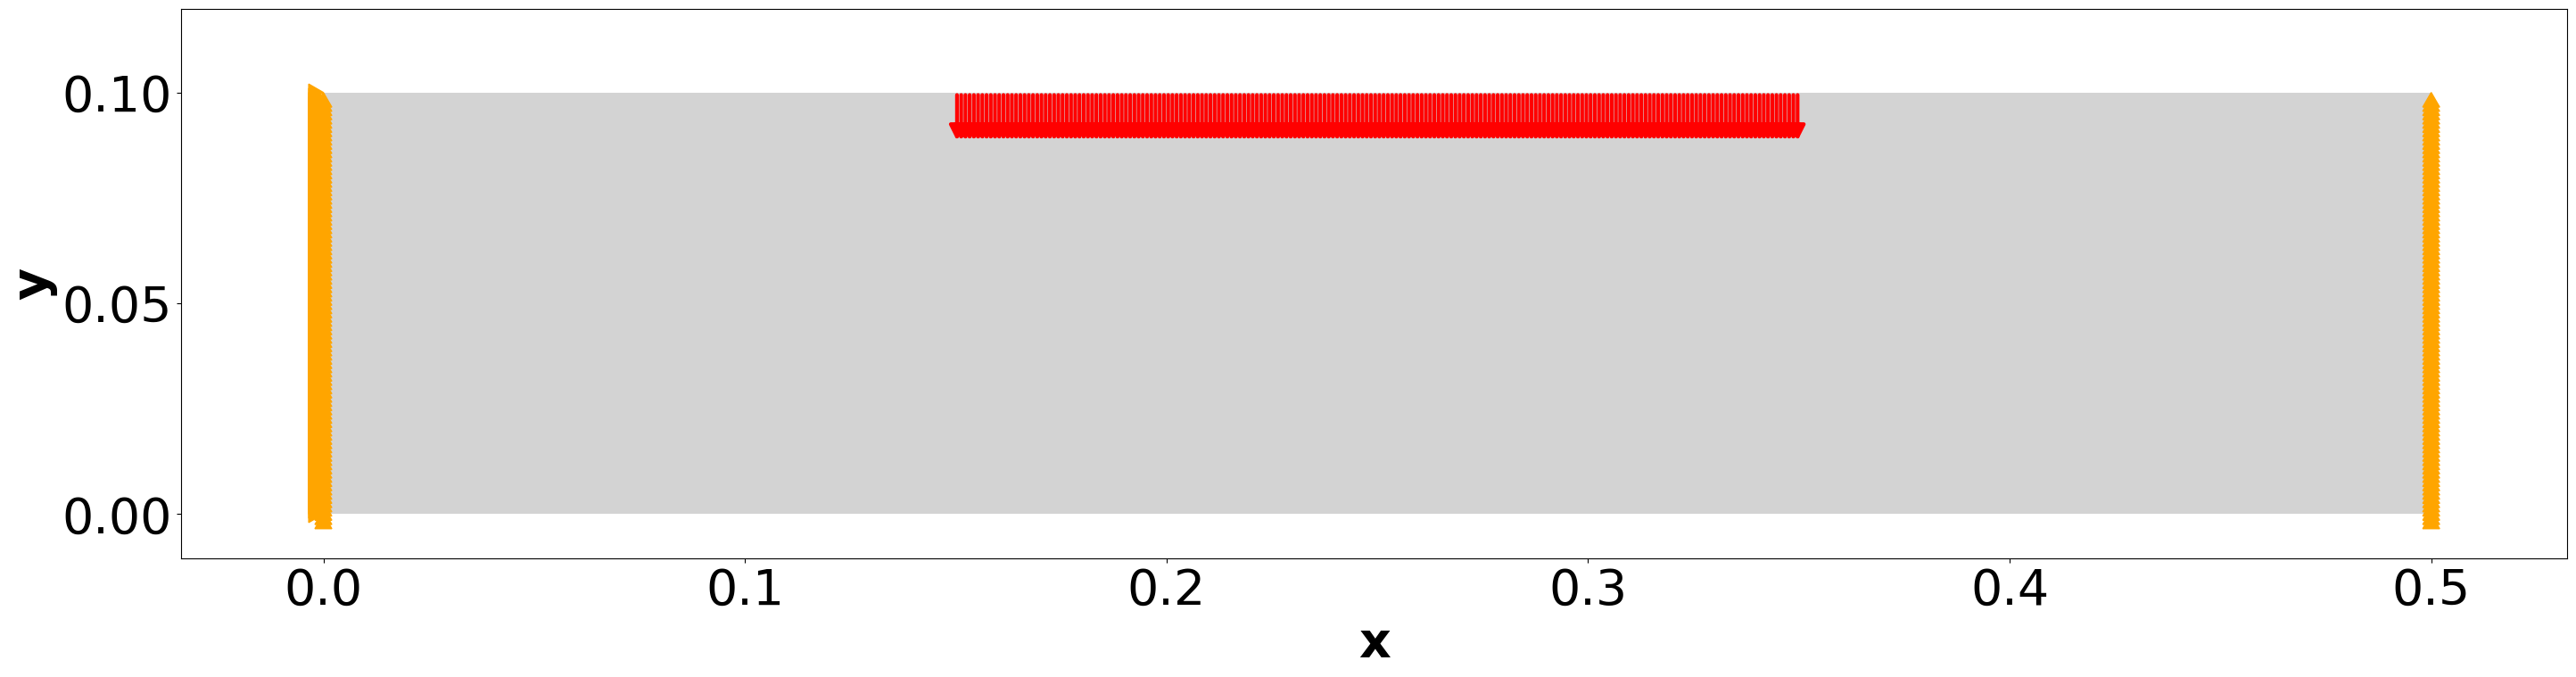

In [42]:
##----------Constraints/Boundary conditions - Force vector assembly----------##
###############################################################################
fixed_DOFs, free_DOFs, loaded_DOFs, F = BC_loads(Mesh, Gauss_points, int_precision, float_precision)
###############################################################################

In [43]:
##----------------------------------Solve------------------------------------##
###############################################################################
U = solve(K, free_DOFs, F, float_precision)
###############################################################################

Solution started



/tmp/ipython-input-3234799313.py:713: SparseEfficiencyWarning: splu converted its input to CSC format
  K_effective_LU = sparse.linalg.splu(K_effective)



Solution is completed | Time taken: 2.16 s



In [45]:
##-------------------------------Post-processing-----------------------------##
###############################################################################
Post_processor = Post_processing2D()
###############################################################################

Available variables to plot:  ['Ux', 'Uy', 'U_abs', 'Sxx', 'Syy', 'Sxy', 'S_VonMises']
Enter the variable you want to plot: Ux

State if you want to plot the mesh (Y/N): N

State if you want to plot the deformed configuration (Y/N): N


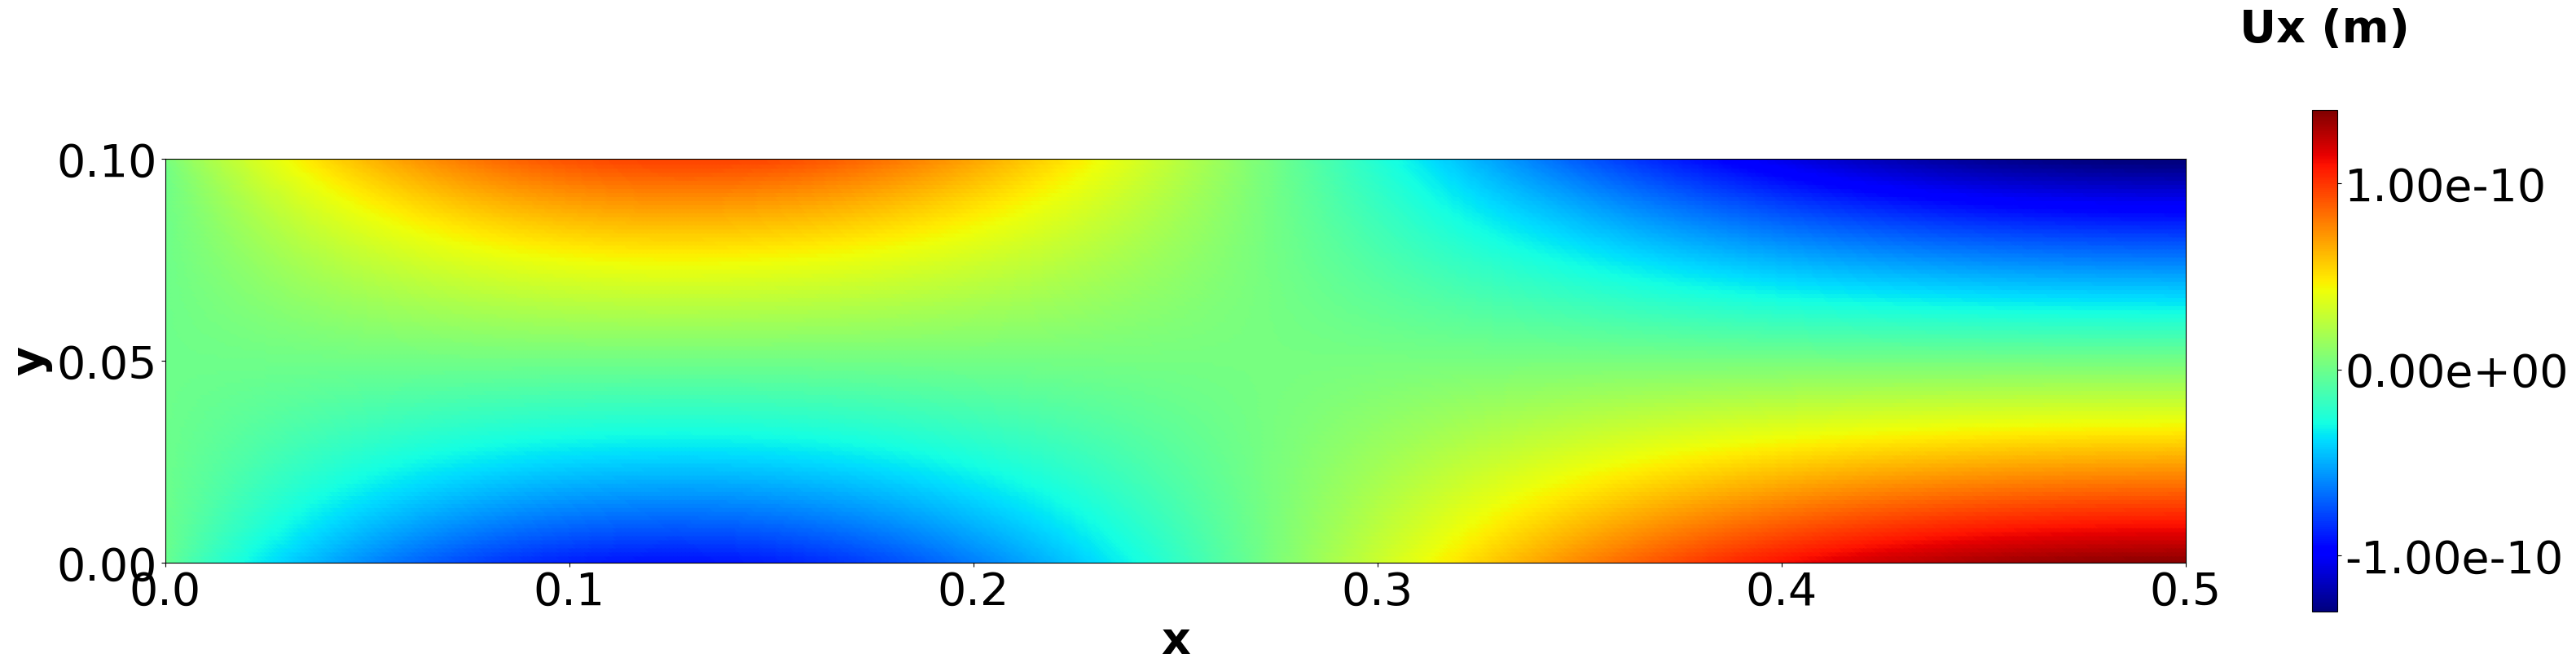

In [46]:
##------------------------------Plot y-displacement-------------------------##
##############################################################################
#Enter Uy from keyboard
Post_processor.plotVar(Mesh, C_e, U, Gauss_points, float_precision)
##############################################################################

Available variables to plot:  ['Ux', 'Uy', 'U_abs', 'Sxx', 'Syy', 'Sxy', 'S_VonMises']
Enter the variable you want to plot: Uy

State if you want to plot the mesh (Y/N): N

State if you want to plot the deformed configuration (Y/N): N


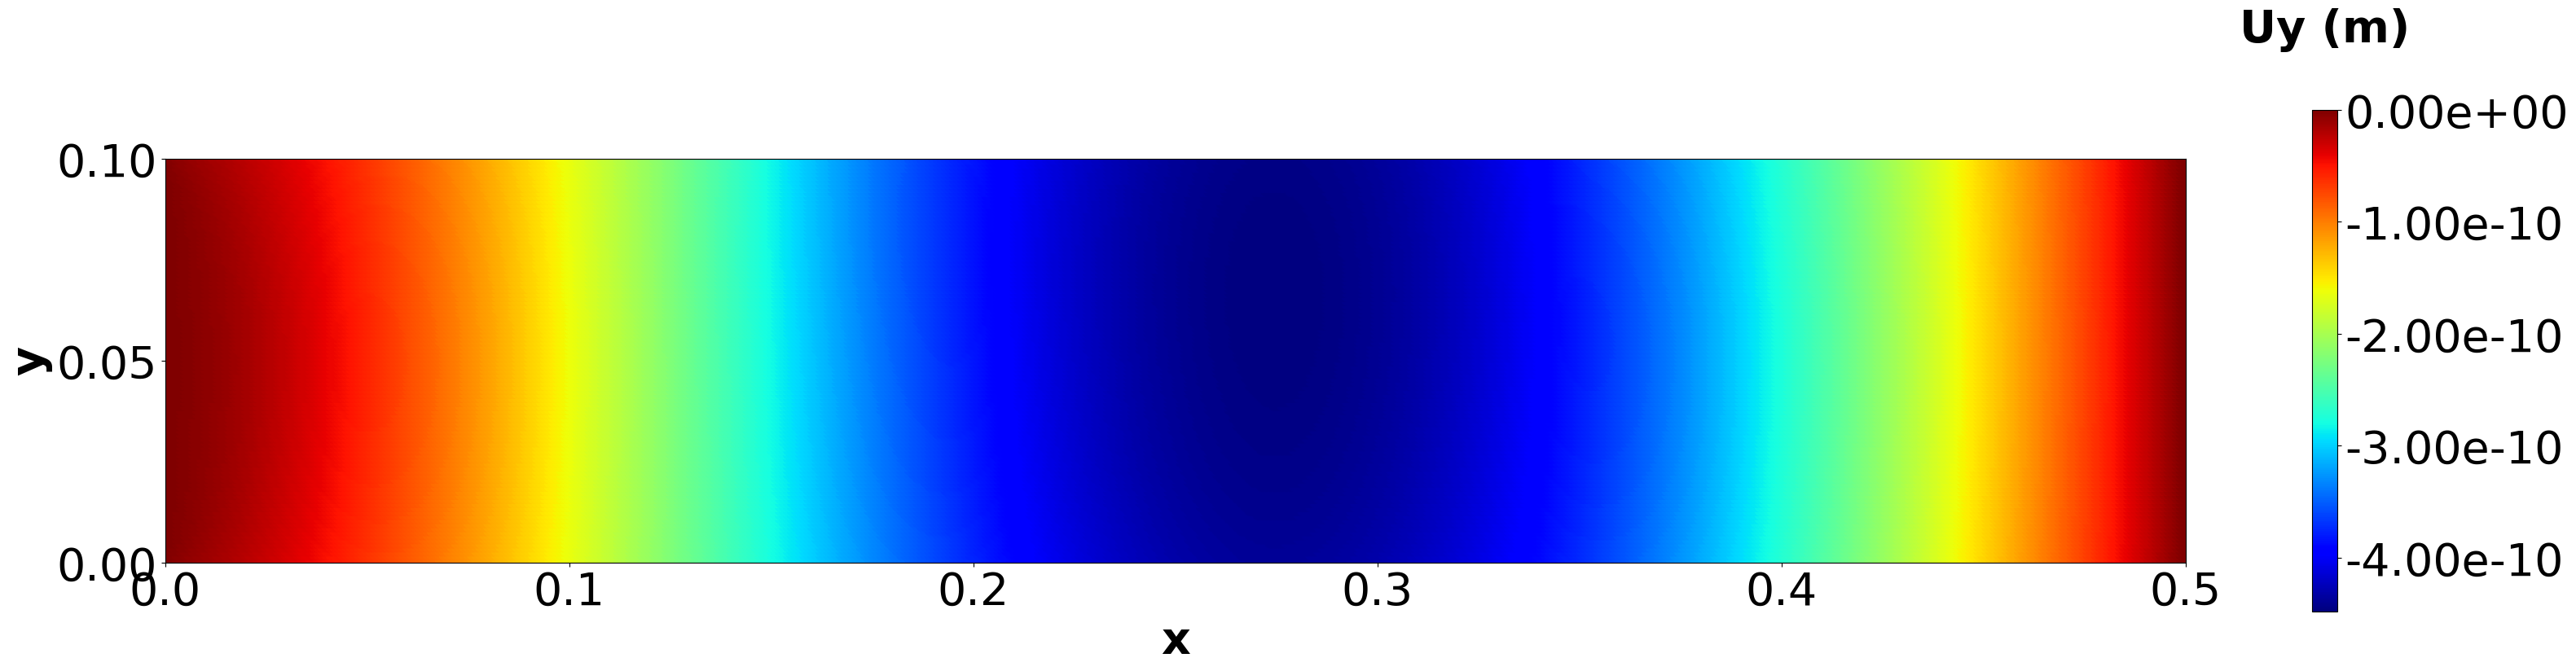

In [47]:
##------------------------------Plot y-displacement-------------------------##
##############################################################################
#Enter Uy from keyboard
Post_processor.plotVar(Mesh, C_e, U, Gauss_points, float_precision)
##############################################################################

Available variables to plot:  ['Ux', 'Uy', 'U_abs', 'Sxx', 'Syy', 'Sxy', 'S_VonMises']
Enter the variable you want to plot: U_abs

State if you want to plot the mesh (Y/N): N

State if you want to plot the deformed configuration (Y/N): N


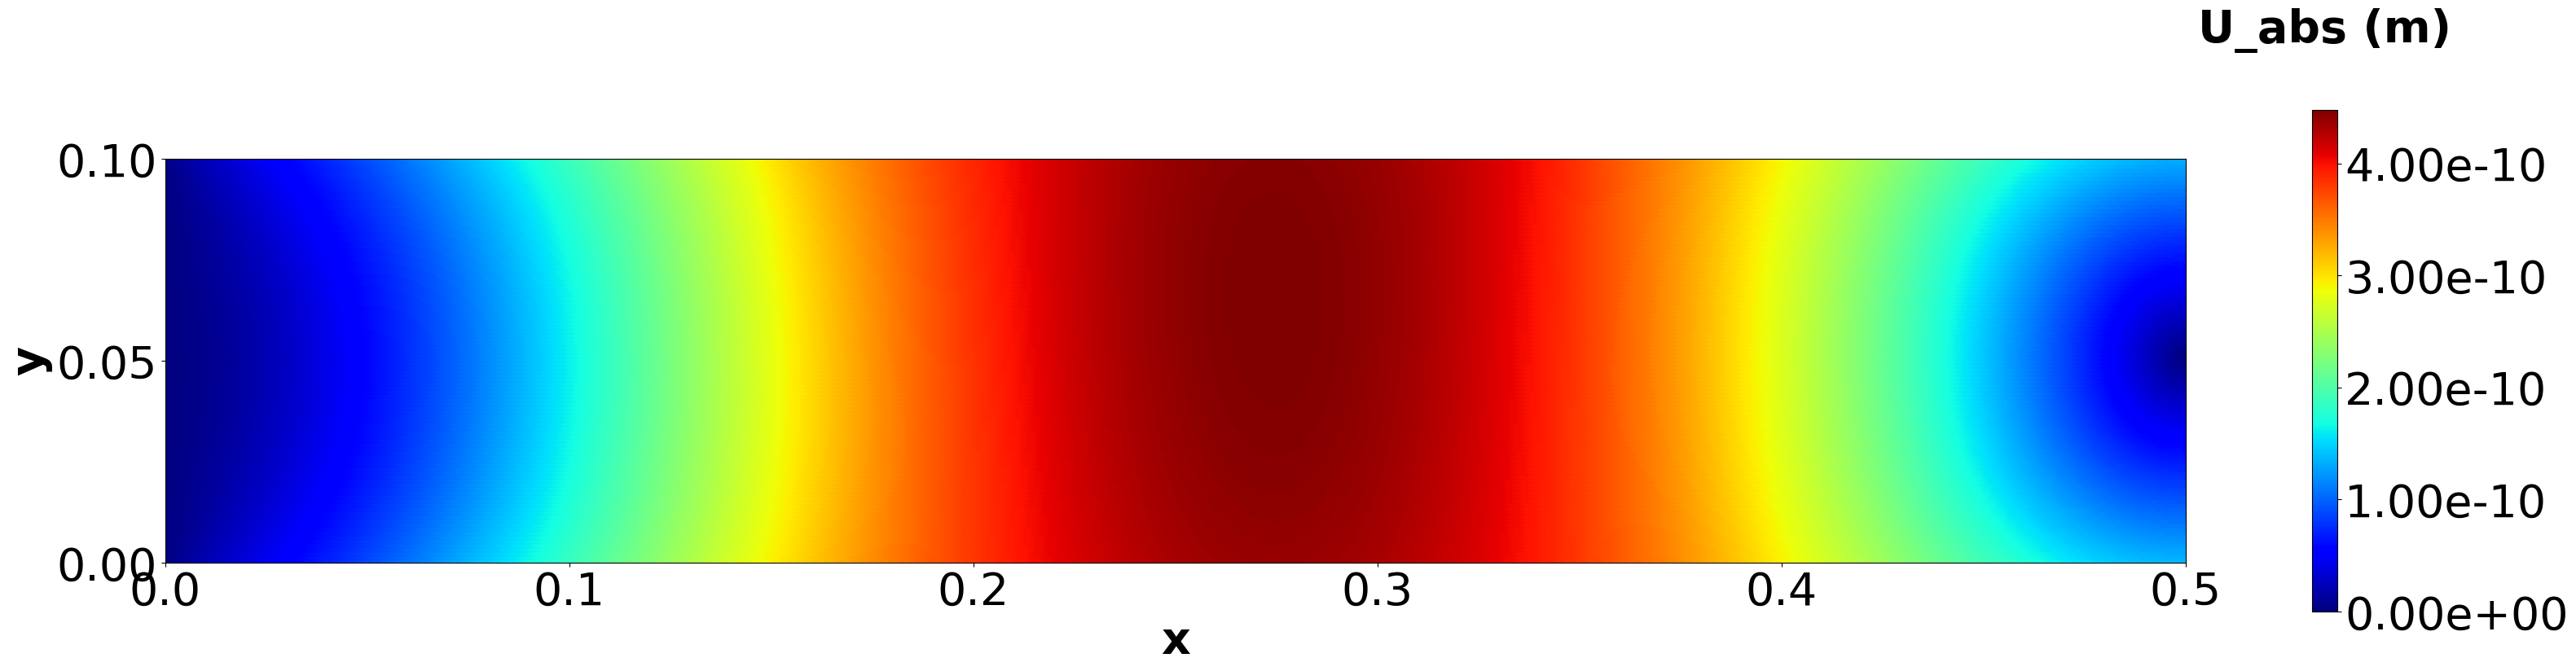

In [48]:
##-----------------------------Plot abs displacement------------------------##
##############################################################################
#Enter U_abs from keyboard
Post_processor.plotVar(Mesh, C_e, U, Gauss_points, float_precision)
##############################################################################

Available variables to plot:  ['Ux', 'Uy', 'U_abs', 'Sxx', 'Syy', 'Sxy', 'S_VonMises']
Enter the variable you want to plot: Sxx

State if you want to plot the mesh (Y/N): N

State if you want to plot the deformed configuration (Y/N): N


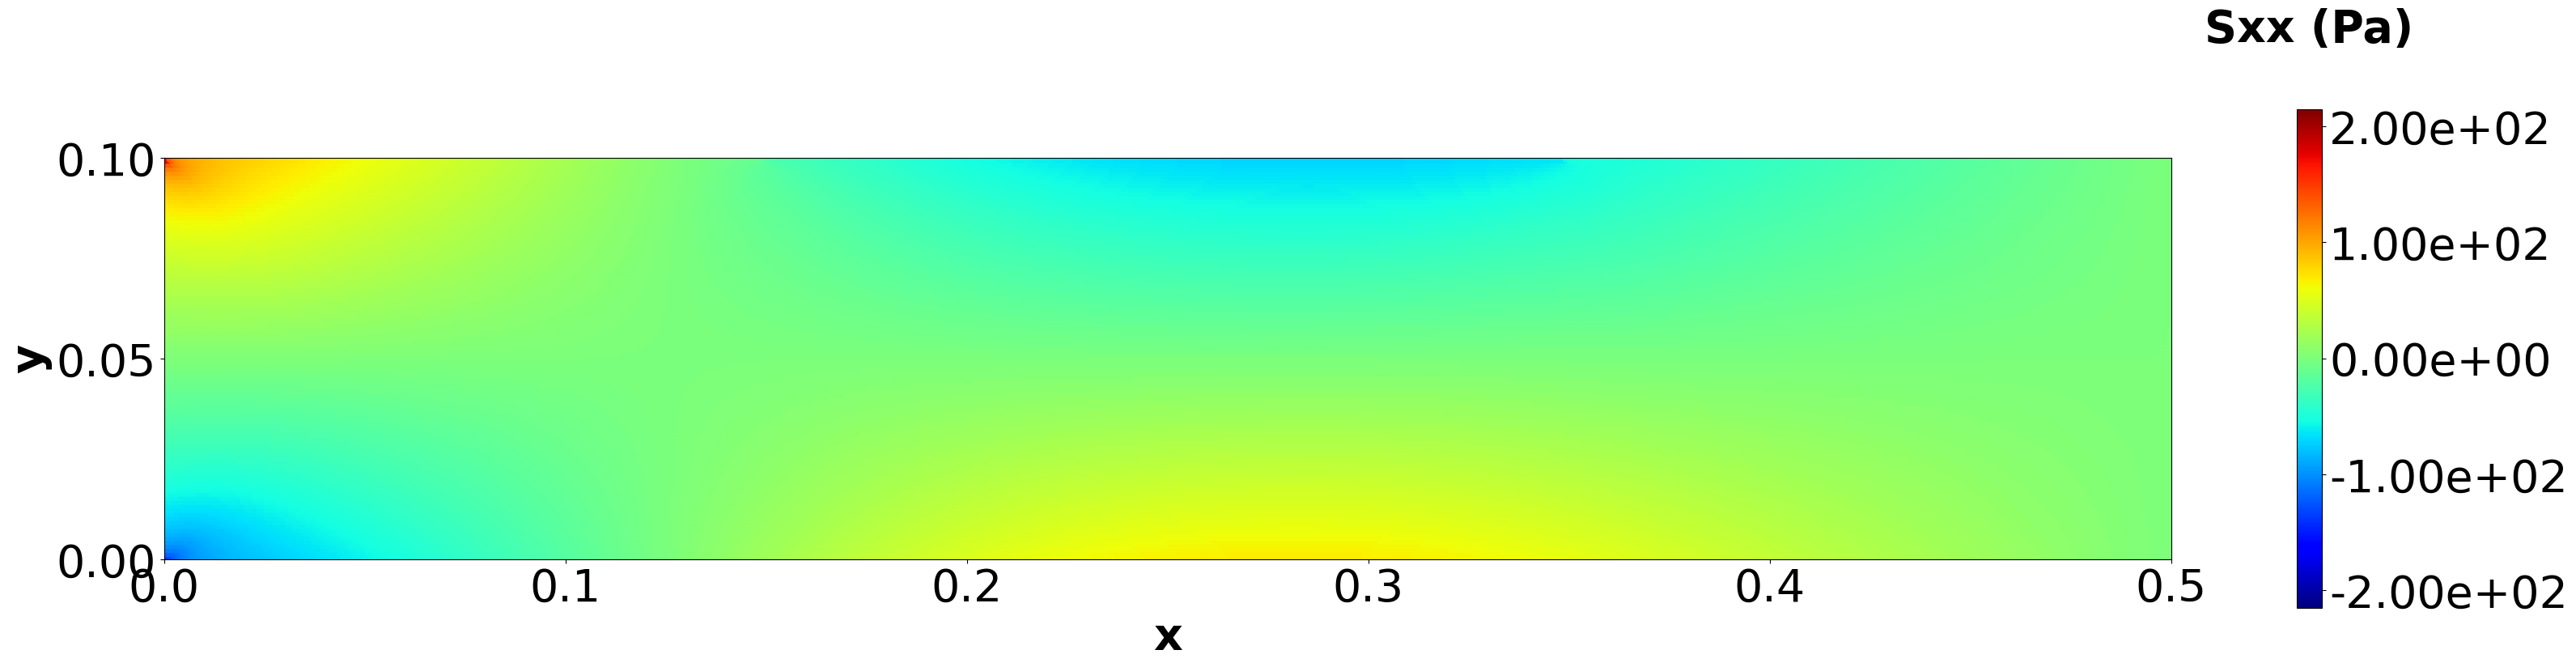

In [49]:
##--------------------------------Plot Sxx stress---------------------------##
##############################################################################
#Enter Sxx from keyboard
Post_processor.plotVar(Mesh, C_e, U, Gauss_points, float_precision)
##############################################################################

Available variables to plot:  ['Ux', 'Uy', 'U_abs', 'Sxx', 'Syy', 'Sxy', 'S_VonMises']
Enter the variable you want to plot: Syy

State if you want to plot the mesh (Y/N): N

State if you want to plot the deformed configuration (Y/N): N


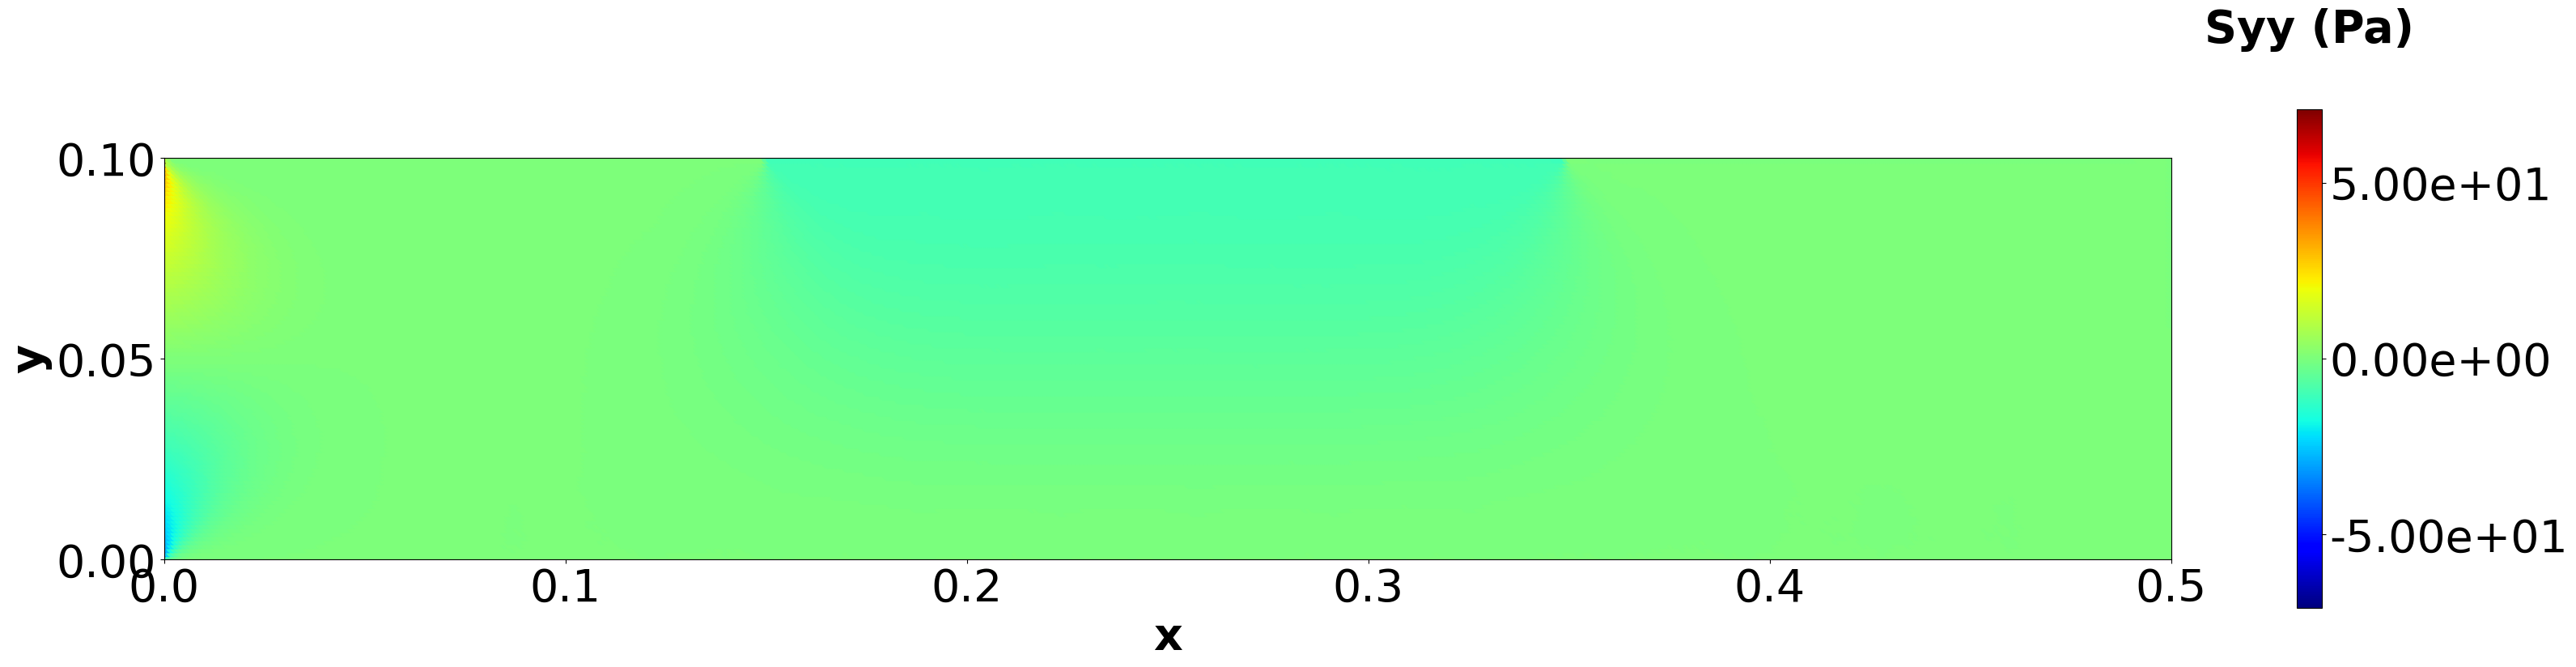

In [50]:
##--------------------------------Plot Syy stress---------------------------##
##############################################################################
#Enter Syy from keyboard
Post_processor.plotVar(Mesh, C_e, U, Gauss_points, float_precision)
##############################################################################

Available variables to plot:  ['Ux', 'Uy', 'U_abs', 'Sxx', 'Syy', 'Sxy', 'S_VonMises']
Enter the variable you want to plot: Sxy

State if you want to plot the mesh (Y/N): N

State if you want to plot the deformed configuration (Y/N): N


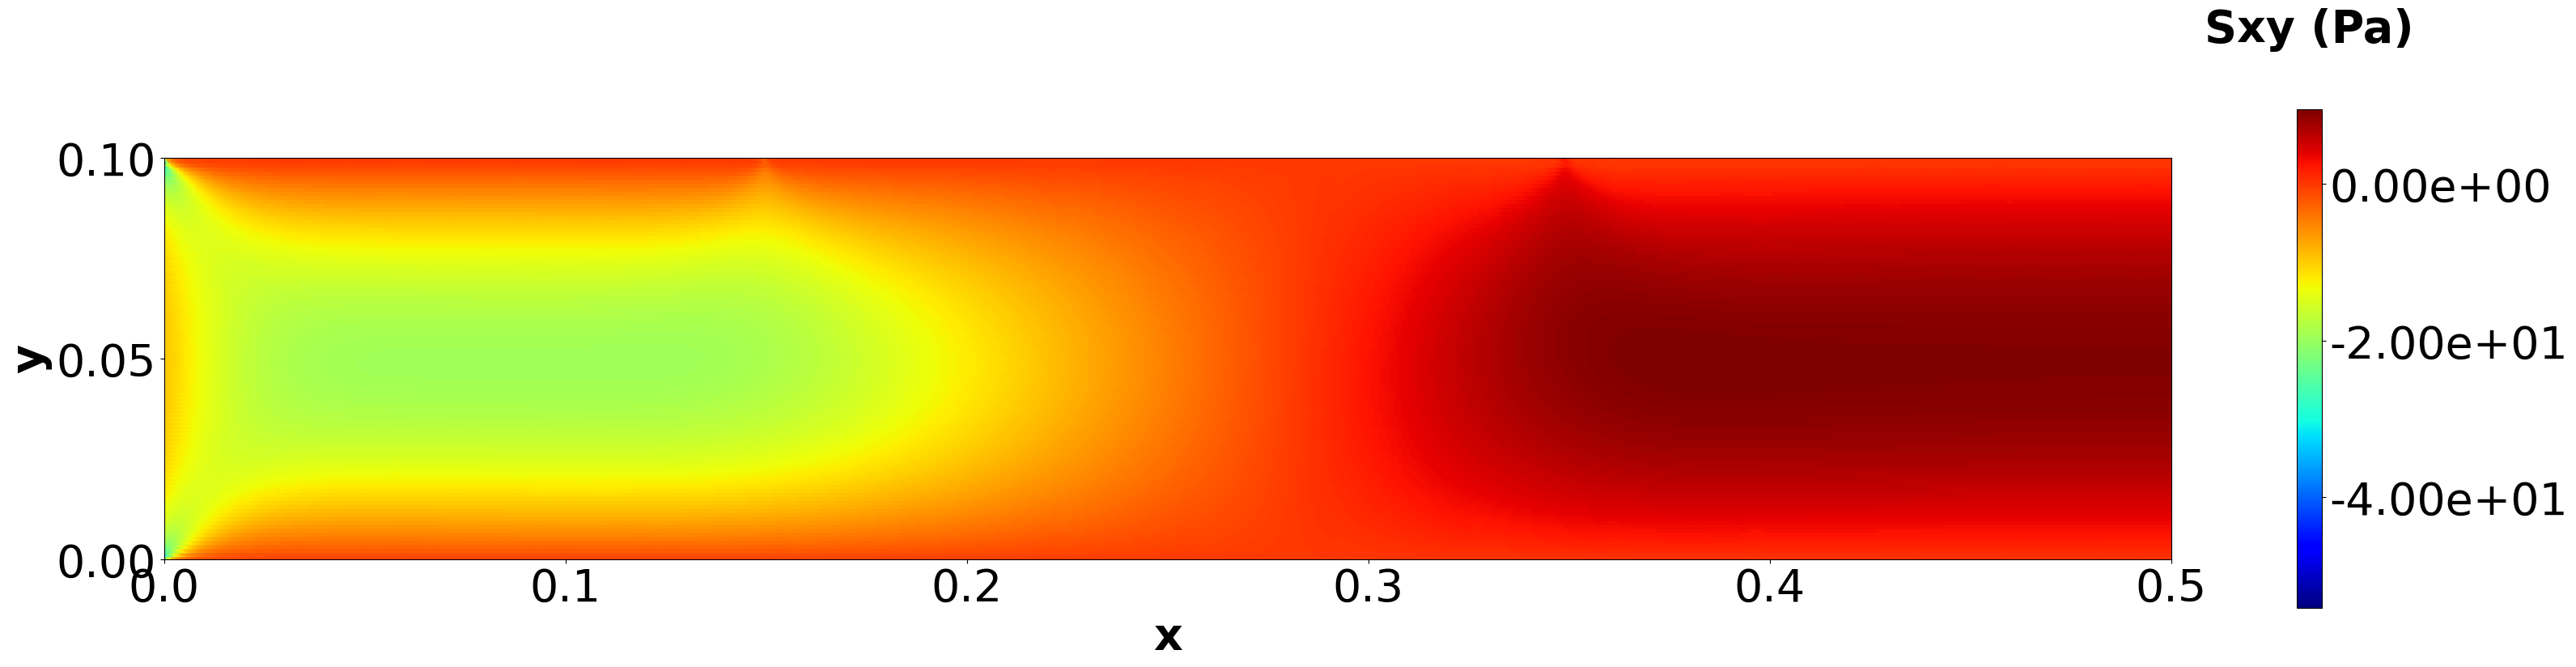

In [51]:
##--------------------------------Plot Sxy stress---------------------------##
##############################################################################
#Enter Sxy from keyboard
Post_processor.plotVar(Mesh, C_e, U, Gauss_points, float_precision)
##############################################################################

Available variables to plot:  ['Ux', 'Uy', 'U_abs', 'Sxx', 'Syy', 'Sxy', 'S_VonMises']
Enter the variable you want to plot: S_VonMises

State if you want to plot the mesh (Y/N): N

State if you want to plot the deformed configuration (Y/N): N


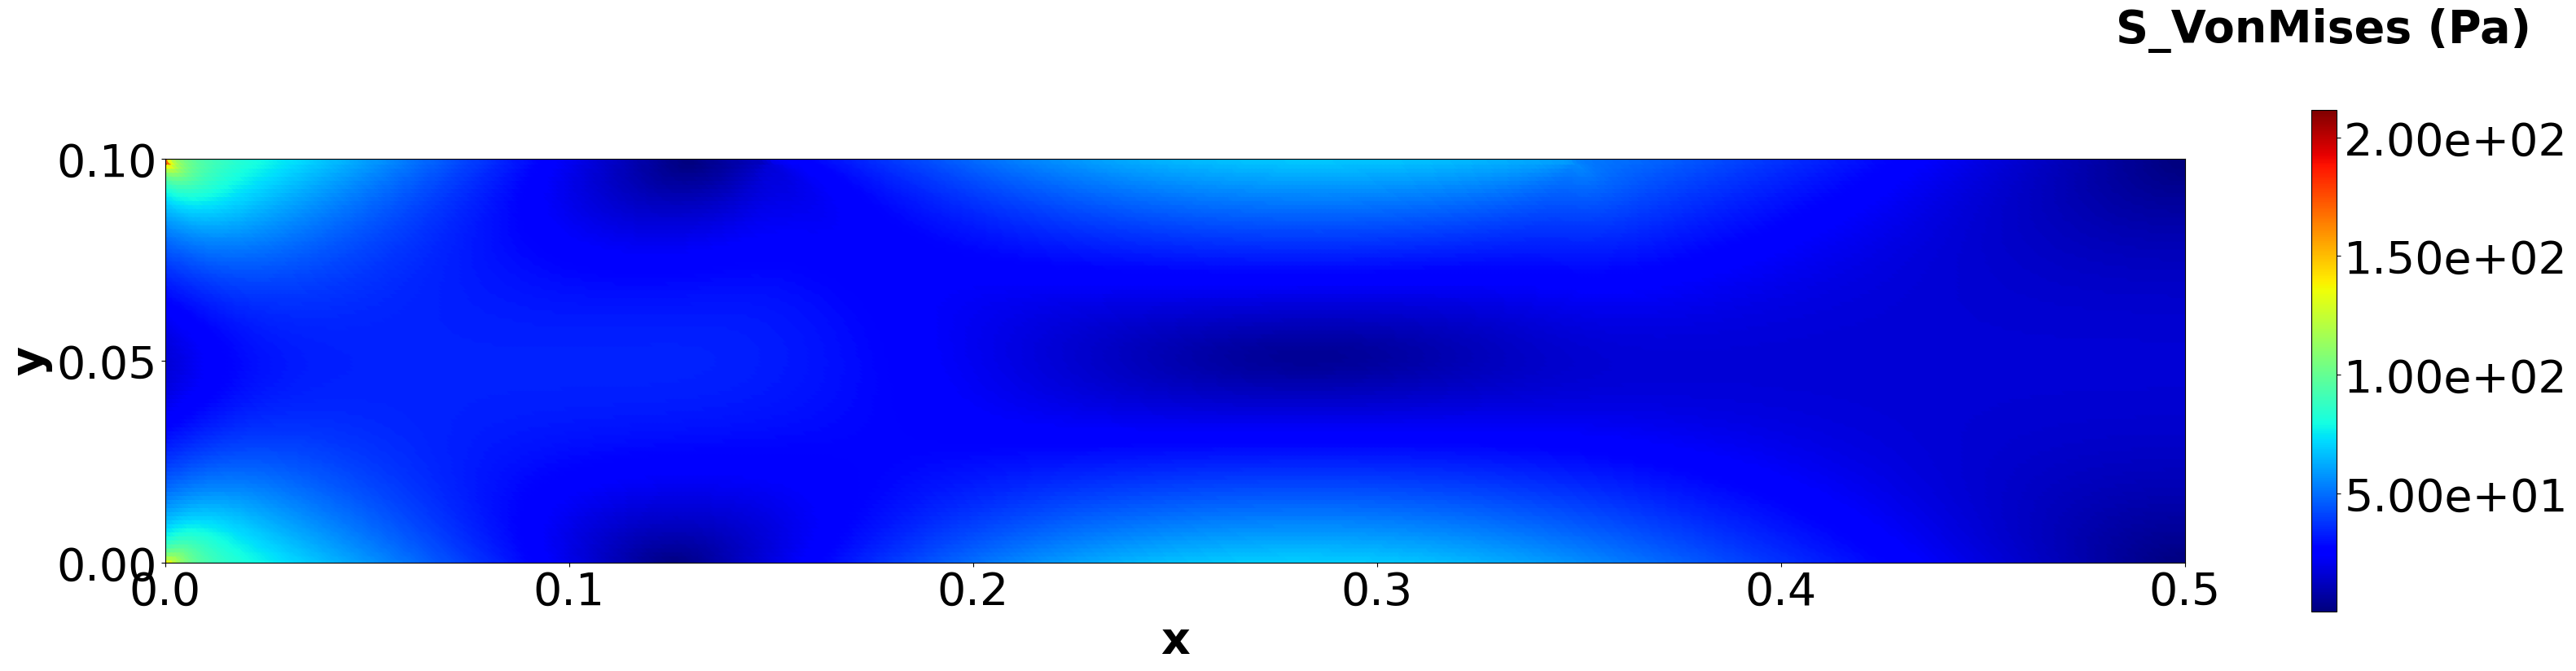

In [52]:
##-----------------------------Plot VonMises stress-------------------------##
##############################################################################
#Enter S_VonMises from keyboard
Post_processor.plotVar(Mesh, C_e, U, Gauss_points, float_precision)
##############################################################################